In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
from IPython.display import clear_output

# Linear Networks

In [2]:
class LinearNetwork(nn.Module):
  def __init__(self, dimensions):
    """
      - dimensions: list of integers representing the number of neurons in each hidden layer
                    dimensions[0] has to be equal to the input dimension
                    dimensions[-1] has to be equal to the output dimension
    """
    super().__init__()
    self.dimensions = dimensions
    self.layers = nn.ModuleList()
    for i in range(1, len(dimensions)):
        self.layers.append(nn.Linear(dimensions[i-1], dimensions[i], bias=False))   # homogeneous model, no bias

  def w(self):
    identity_tensor = torch.eye(self.dimensions[0], dtype=torch.float32, device=self.device)
    w_tens = self.forward(identity_tensor)
    return w_tens.detach().cpu().numpy().flatten()

  def get_layer(self, i):
    if i < 0 or i >= len(self.layers):
        raise ValueError("Invalid layer index")
    return self.layers[i].weight

  def parameter_norm(self, p, layer='all'):
    if layer == 'all':
          norm = 0.0
          for param in self.parameters():
              norm += torch.pow(torch.abs(param), p).sum()
          return np.power(norm.item(), 1/p)
    else:
      param = self.layers[layer].weight
      return np.power(torch.pow(torch.abs(param), p).sum().item(), 1/p)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class FCN(nn.Module):
  def __init__(self, dimensions):
    """
      - dimensions: list of integers representing the number of neurons in each hidden layer
                    dimensions[0] has to be equal to the input dimension
                    dimensions[-1] has to be equal to the output dimension
    """
    super().__init__()
    self.layers = nn.ModuleList()
    for i in range(1, len(dimensions)):
        self.layers.append(nn.Linear(dimensions[i-1], dimensions[i], bias=False))   # homogeneous model, no bias

  def parameter_norm(self, p):
          norm = 0.0
          for param in self.parameters():
              norm += torch.pow(torch.abs(param), p).sum()
          return np.power(norm.item(), 1/p)


  def forward(self, x):
    output = x
    for layer in self.layers:
      output = nn.ReLU(layer(output))
    return output


# Bregman Divergence


In [3]:
def bregman_div(x, y, p):
  # assumes x and y to be numpy arrays of the same shape
  # computes the bregman divergence D_\psi(x,y) for \psi(z)=p^{-1} |z|_p^p
  # compute nabla psi (y):
  dim = x.shape[0]
  nabla_psi_y = np.zeros(dim)
  for i in range(dim):
    nabla_psi_y[i] = np.sign(y[i]) * np.power(np.abs(y[i]), p-1)
  return np.linalg.norm(x, ord=p)/p - np.linalg.norm(y, ord=p)/p - np.dot(nabla_psi_y, x-y)

# Implementing Mirror Descent ($p$-Gradient Descent)
Implementation based on https://arxiv.org/pdf/2306.13853v1.pdf Appendix H

In [4]:
class pGradientDescent(Optimizer):
  def __init__(self, params, p=2.0, lr=1e-3):
    if p <= 1:
      raise ValueError(f"Invalid p: {p}, should be larger than 1")

    self.p = p
    defaults = dict(lr=lr, p=p)
    super(pGradientDescent, self).__init__(params, defaults)

  def __setstate__(self, state):
    super(pGradientDescent, self).__setstate__(state)

  def step(self, closure=None):
    loss = None
    if closure is not None :
      with torch.enable_grad() :
        loss = closure()

    for group in self.param_groups:
      lr = group["lr"]
      p = group["p"]

      for param in group["params"]:
        if param.grad is None :
          continue

        x , dx = param.data , param.grad.data

        update = torch.pow(torch.abs(x), p-1) * torch.sign(x) - lr * dx
        param.data = torch.sign(update) * torch.pow (torch.abs(update), 1/(p-1))
    return loss

# Margins
Here we implement a method to compute the margin $$\gamma(\omega):=\min_{i=1,\dots,N}y_i\langle x_i,\omega\rangle.$$

In [5]:
def margin(model, dataloader):
  gamma = np.inf
  for batch_x, batch_y in dataloader:
    for i in range(batch_x.shape[0]):
      x = batch_x[i]
      y = batch_y[i]
      if(y*model(x) < gamma):
        gamma = y*model(x)
  return gamma

# Loss Functions

In [6]:
class ExponentialLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(ExponentialLoss, self).__init__()
        self.alpha = alpha

    def forward(self, y_true, y_pred):
        loss = torch.exp(-self.alpha * (y_true * y_pred))
        return loss.mean()


# Artificial Datasets

In [7]:
class LinearlySeparableDataset(Dataset):
    def __init__(self, num_samples=100, dim=2, random_seed=42):
        super(LinearlySeparableDataset, self).__init__()
        self.data = 10*(torch.rand((num_samples, dim))-0.5)
        self.slope = torch.rand(dim)

        self.labels = 2*((self.data @ self.slope) > 0).float()-1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]),  torch.tensor(self.labels[idx])


In [8]:
class TwoCircles(Dataset):
    def __init__(self, num_samples=100, dim=2, random_seed=42):
        self.data, self.labels = self.__create_circles__(num_samples, dim)

    def __create_circles__(self, num_samples, dim):
        x = np.zeros((num_samples,dim))
        y = np.zeros(num_samples)

        x[0][0] = 1.0
        y[0] = 1
        x[1][0] = -1.0
        y[1] = -1

        for i in range(2, num_samples):
          x[i] = np.random.normal(loc=0.0, scale=1.0, size=dim)
          x[i] = x[i]/np.linalg.norm(x[i])
          y[i] = 2*np.random.randint(0,2)-1

          if(y[i]>0):
            x[i][0] += 2.0
          else:
            x[i][0] -= 2.0
        return x , y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32),  torch.tensor(self.labels[idx], dtype=torch.float32)


In [9]:

def visualize_model2D(models, data_loader, title):
  """
    - models: list of models
    - data_loder: DataLoader returning batches of pairs (x,y) with x being two-dimensional and y being +1/-1
  """
  num_models = len(models)
  if(num_models==1):
    model = models[0]
    model.to("cpu")
    model.eval()
    data, labels = next(iter(data_loader))

    data1 = data[labels == 1]
    data0 = data[labels == -1]
    plt.scatter(data1[:, 0], data1[:, 1], c='r', marker='o', edgecolors='k', s=50)
    plt.scatter(data0[:, 0], data0[:, 1], c='b', marker='x', edgecolors='k', s=50)
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    mesh_tensor = torch.tensor(mesh_data, dtype=torch.float32)

    with torch.no_grad():
        model.eval()
        predictions = torch.sign(model(mesh_tensor)).cpu().numpy()

    plt.contourf(xx, yy, predictions.reshape(xx.shape), alpha=0.3, cmap='viridis')
    plt.title(title)
    plt.show()
    return 0

  fig, axes = plt.subplots(1, num_models, figsize=(12, 8))
  for i in range(num_models):
    model = models[i]
    model.eval()
    data, labels = next(iter(data_loader))

    data1 = data[labels == 1]
    data0 = data[labels == -1]
    axes[i].scatter(data1[:, 0], data1[:, 1], c='r', marker='o', edgecolors='k', s=50)
    axes[i].scatter(data0[:, 0], data0[:, 1], c='b', marker='x', edgecolors='k', s=50)

    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    mesh_tensor = torch.tensor(mesh_data, dtype=torch.float32)

    with torch.no_grad():
        model.eval()
        predictions = torch.sign(model(mesh_tensor)).cpu().numpy()

    axes[i].contourf(xx, yy, predictions.reshape(xx.shape), alpha=0.3, cmap='viridis')
  plt.title(title)
  plt.show()


# Training

We train models with various values of $p$ for 10000 epochs, recording the $q$-norm of the normalized (by $\gamma(\omega)^{-1}$) final parameters for $p,q\in \{1.1, 1.3, 2.0, 3.0, 5.0, 10.0\}$. \
This is repeated 10 times for each $p$.

In [10]:
num_repetitions = 2
p_norms = [1.1, 1.3, 2.0, 3.0, 5.0]
results = np.zeros((num_repetitions, len(p_norms), len(p_norms)))
epochs = 10000
dim = 10
num_samples = 10

dataset = LinearlySeparableDataset(num_samples=num_samples, dim=dim)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

for i in range(len(p_norms)):      # loop through all possible values of p
  p = p_norms[i]
  for j in range(num_repetitions):             # repeat experiment
    model = LinearNetwork([dim, 1])
    optimizer = pGradientDescent(model.parameters(), lr=1e-3, p=p)
    loss_fn = ExponentialLoss()

    # training
    for _ in range(epochs):
      for x, y in dataloader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss_fn(y_pred[:,0], y).backward()
        optimizer.step()

    # compute q-norms of parameters
    for k in range(len(p_norms)):
      results[j, i, k] = model.parameter_norm(p_norms[k])


<ipython-input-7-99630a32fda6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx]),  torch.tensor(self.labels[idx])


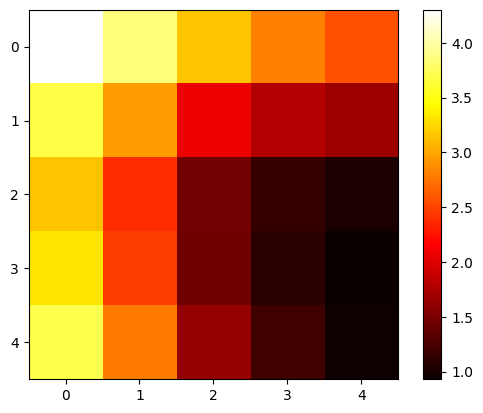

In [14]:
plt.imshow(np.mean(results, axis=0), cmap='hot')
plt.colorbar()

# Growth Rate of Parameter Norms
In https://arxiv.org/pdf/2306.13853v1.pdf Lemma 18 it was shown that the $\psi$-norm of the parameters of a linear model trained with mirror descent grow logarithmically.

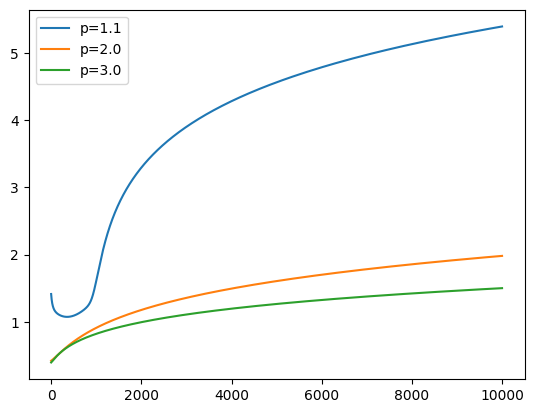

In [17]:
# linear model
epochs = 10000

dim = 10
num_samples = 10

#dataset = LinearlySeparableDataset(num_samples=num_samples, dim=dim)
dataset = TwoCircles(num_samples=num_samples, dim=dim)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


for p in [1.1, 2.0, 3.0]:
  model = LinearNetwork([dim, 1])
  optimizer = pGradientDescent(model.parameters(), lr=1e-3, p=p)
  loss_fn = ExponentialLoss()

  norms = []

  # training
  for _ in range(epochs):
    norms.append(model.parameter_norm(p))
    for x, y in dataloader:
      optimizer.zero_grad()
      y_pred = model(x)
      loss_fn(y_pred[:,0], y).backward()
      optimizer.step()

  plt.plot(np.linspace(0,epochs,epochs), norms, label=f"p={p}")

#plt.xscale('log')  # Set y-axis to logarithmic scale
plt.legend()
plt.show()


# Do the Linear Model and the Linear Network converge in the same direction?
We train a linear model and a linear network on the 'TwoCircles' dataset and compare their (normalized) output to the max-margin solution, the first unit vector.

(Optionally, use 'visualize_model2D' to plot the decision boundaries during trainning, disable GPU usage if you use this method)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

dim = 2

epochs = 100000
p = 1.1
lr = 1e-4
num_samples = 100


#dataset = LinearlySeparableDataset(num_samples=num_samples, dim=dim)
dataset = TwoCircles(num_samples, dim=dim)
dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)

hard_margin_w = np.zeros(dim)
hard_margin_w[0] = 1.0          # solution of hard-margin SVM is (approximately) the first unit vector


loss_curves1 = []
loss_curves2 = []

linearModel = LinearNetwork([dim,1])
lineaModel = linearModel.to(device)
linearModel.device = device

deepLinNet = LinearNetwork([dim,dim,1])
deepLinNet = deepLinNet.to(device)
deepLinNet.device = device


# set initial param of 'linearModel' s.t. the output fct. is the same as that of 'deepLinNet'
w = torch.tensor([deepLinNet.w()])
w = w.to(device)

linearModel.layers[0].weight.data = w


optimizer1 = pGradientDescent(linearModel.parameters(), lr=lr, p=p)
optimizer2 = pGradientDescent(deepLinNet.parameters(), lr=lr, p=p)

loss_fn1 = ExponentialLoss()
loss_fn2 = ExponentialLoss()

diff1 = []
diff2 = []

hard_margin_w = np.zeros(dim)
hard_margin_w[0] = 1.0          # solution of hard-margin SVM is (approximately) the first unit vector

# visualize initial output functions
# visualize_model2D([linearModel, deepLinNet], dataloader, f"Model output at initialization")


# training
for _ in range(1, epochs+1):
  for x, y in dataloader:
    x = x.to(device)
    y = y.to(device)

    # update linear model
    optimizer1.zero_grad()
    y_pred = linearModel(x)
    loss_fn1(y_pred[:,0], y).backward()
    optimizer1.step()

    # update deep linear net
    optimizer2.zero_grad()
    y_pred = deepLinNet(x)
    loss_fn2(y_pred[:,0], y).backward()
    optimizer2.step()

    # calculate directions
    w1, w2 = linearModel.w(), deepLinNet.w()
    dir1, dir2 = w1/np.linalg.norm(w1), w2/np.linalg.norm(w2)   # normalize weight vectors

    diff1.append(bregman_div(dir1, hard_margin_w, p))          #  TODO: maybe compute bregman divergences instead?
    diff2.append(bregman_div(dir2, hard_margin_w, p))


    if(_ % (epochs/100) == 0):
      plt.plot(diff1, c='b', label="Linear Model")
      plt.plot(diff2, c='r', label="Linear Network")
      plt.title(f"Differences: {diff1[-1]} for the linear model, {diff2[-1]} for the linear network, p={p}")
      plt.yscale('log')  # Set y-axis to logarithmic scale
      plt.xlabel('Epochs')
      plt.ylabel('Bregman Divergence of $w_t$ and $w^*$')
      plt.legend()
      plt.show()
      clear_output(wait=True)
      # if(dim==2):
      #   if (_%(epochs/10)==0):
      #     clear_output(wait=True)
      #     visualize_model2D([linearModel, deepLinNet], dataloader, f"Decision boundaries after epoch {_}")


plt.plot(diff1, c='b', label="Linear Model")
plt.plot(diff2, c='r', label="Linear Network")
plt.title(f"Final differences: {diff1[-1]} for the linear model, {diff2[-1]} for the linear network, p={p}")
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Bregman Divergence of $w_t$ and $w^*$')
plt.legend()
plt.show()

KeyboardInterrupt: 

# What is the rank of the trained weight matrices in a linear network?
In ["Gradient descent aligns the layers of deep linear networks"](https://arxiv.org/pdf/1810.02032.pdf) Theorem 2.2 it was shown that under Gradient Flow, the trained weight matrices of each layer are well-approximated by their rank-1-approximation $u_kv_k^T$, where $u_k$ and $v_k$ denote the first right and left singular vectors of the weight matrix $W_k$ of the $k$-th layer.

To see if a similar phenomenon occurs for Mirror Descent, we plot the singular value distribution during training to see if the weight matrices converge to rank-1 matrices.

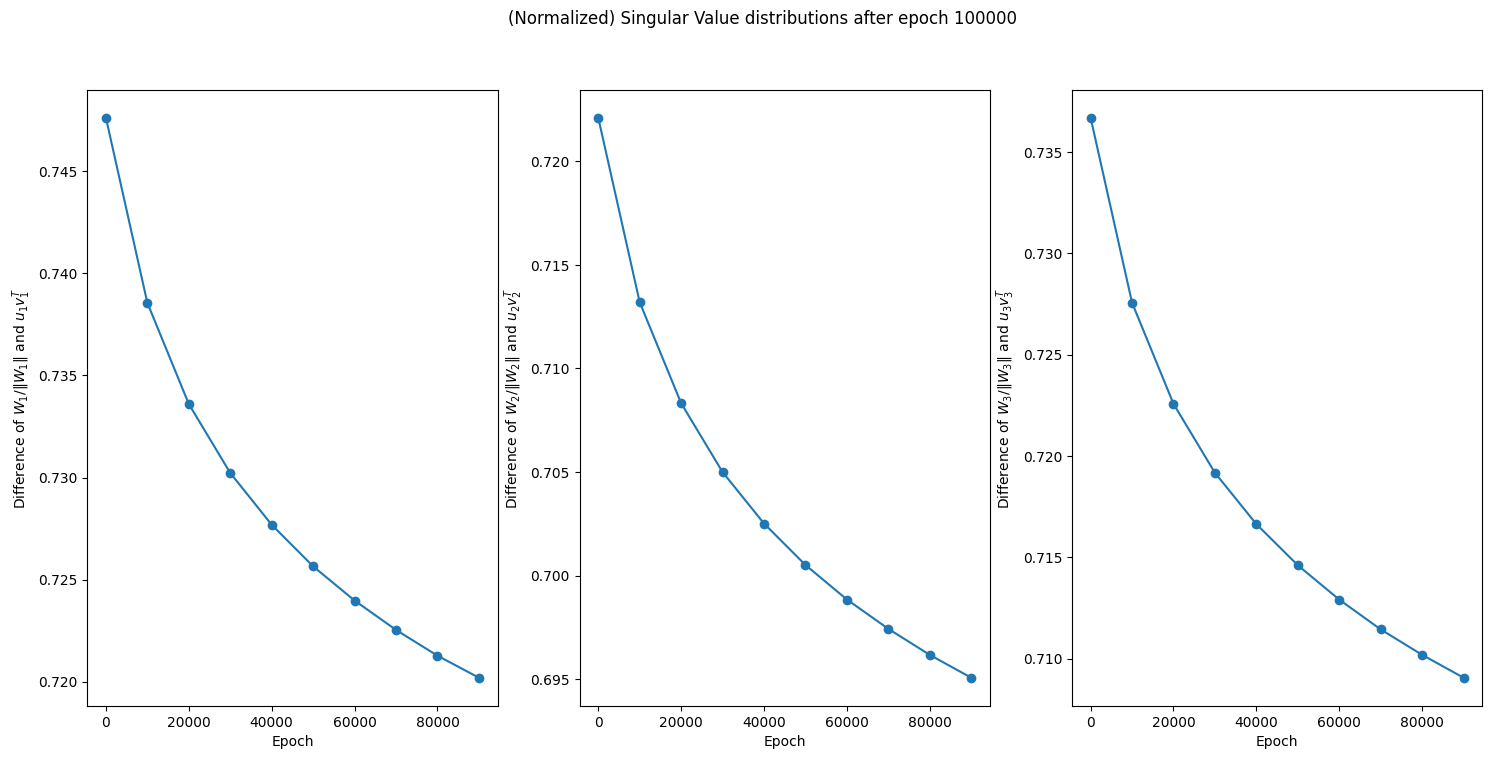

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

dim = 10
layers = 4
network_dimensions = [dim]*layers
network_dimensions.append(1)

epochs = 100000
p = 2.0
lr = 1e-1
num_samples = 20


#dataset = LinearlySeparableDataset(num_samples=num_samples, dim=dim)
dataset = TwoCircles(num_samples, dim=dim)
dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)

hard_margin_w = np.zeros(dim)
hard_margin_w[0] = 1.0          # solution of hard-margin SVM is (approximately) the first unit vector


loss_curves1 = []

deepLinNet = LinearNetwork(network_dimensions)
deepLinNet = deepLinNet.to(device)
deepLinNet.device = device

optimizer = pGradientDescent(deepLinNet.parameters(), lr=lr, p=p)

loss_fn = ExponentialLoss()

norm_diffs = [[] for _ in range(layers)]

# training
for _ in range(1, epochs+1):
  for x, y in dataloader:
    x = x.to(device)
    y = y.to(device)

    # update deep linear net
    optimizer.zero_grad()
    y_pred = deepLinNet(x)
    loss_fn(y_pred[:,0], y).backward()
    optimizer.step()

    # calculate SVDs of weight matrices
    if( _ % (epochs/10)==0):
      fig, axs = plt.subplots(1, layers-1, figsize=(18, 8))
      for l in range(layers-1):
        W_l = deepLinNet.get_layer(l).to("cpu").detach().numpy()
        norm = deepLinNet.parameter_norm(p=p, layer=l)
        U_l, S_l, Vt_l = np.linalg.svd(W_l)

        # Compute u_1 v_1^T
        u_1 = U_l[:, 0]
        v_1 = Vt_l[0, :]
        u1_v1T = np.outer(u_1, v_1)
        norm_diffs[l].append(np.linalg.norm(W_l/norm - u1_v1T))
        axs[l].plot(np.arange(0, _, epochs/10), norm_diffs[l], marker='o')
        axs[l].set_xlabel("Epoch")
        axs[l].set_ylabel(f"Difference of $W_{l+1}/\Vert W_{l+1}\Vert$ and $u_{l+1}v_{l+1}^T$")
      plt.show()
      clear_output(wait=True)